<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the data from GitHub

In [2]:
# import os
# if not os.path.exists('GEOMAR-DeepLearning'):
#     print(f'GEOMAR-DeepLearning does not exist')
#     !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
#     %cd GEOMAR-DeepLearning/app/backend
#     !git pull
#     !pip install -r requirements.txt
# else:
#     print(f'GEOMAR-DeepLearning exists')
#     %cd GEOMAR-DeepLearning/app/backend
#     !git pull
#     !pip install -r requirements.txt

## Import Libaries

In [3]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from tqdm import tqdm
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

/home/marco/venv/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

In [4]:
START_DATE = '2024-01-01'
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    # "min_lon":10.038345850696412,
    # "max_lon":10.365962458698567,
    # "min_lat":54.27381478077755,
    # "max_lat":54.52976525577923,

    "minimum_longitude":9.85083510071235,
    "maximum_longitude":10.926709174713364,
    "minimum_latitude":54.25206332481298,
    "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [5]:
def process_df(df):
    df = df.dropna(axis=1, how="all")
    df = df.dropna(axis=0, how="any")
    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    df = df.reset_index(drop=True)
    return df

In [6]:
def ouput_file_name(output_filename, minimum_longitude, maximum_longitude):
    output_range = maximum_longitude - minimum_longitude
    output_filename = f'{output_filename}-{START_DATE}-{output_range}.nc'
    return output_filename

In [7]:
copernicus = AdvancedCopernicus()
def load_ocean_data(variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
                    minimum_longitude=BBOX["minimum_longitude"],
                    maximum_longitude=BBOX["maximum_longitude"],
                    minimum_latitude=BBOX["minimum_latitude"],
                    maximum_latitude=BBOX["maximum_latitude"],
                    delete_file=True,
                    output_filename='output'):

    output_filename = ouput_file_name(output_filename, minimum_longitude, maximum_longitude)
    print(f'Output File Name: {output_filename}')
    

    if os.path.exists(output_filename):
        print(f'File {output_filename} already exists')
        return output_filename

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=variables,
        minimum_longitude=minimum_longitude,
        maximum_longitude=maximum_longitude,
        minimum_latitude=minimum_latitude,
        maximum_latitude=maximum_latitude,
        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename=output_filename,
        delete_file=delete_file)

    return data.to_dataframe().reset_index()

training_data = load_ocean_data(
    variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
    minimum_longitude=BBOX["minimum_longitude"],
    maximum_longitude=BBOX["maximum_longitude"],
    minimum_latitude=BBOX["minimum_latitude"],
    maximum_latitude=BBOX["maximum_latitude"], delete_file=False, output_filename='training'
)

target_data = load_ocean_data(
    variables=["sla"],
    minimum_longitude=BBOX["target_min_lon"],
    maximum_longitude=BBOX["target_max_lon"],
    minimum_latitude=BBOX["target_min_lat"],
    maximum_latitude=BBOX["target_max_lat"], delete_file=False, output_filename='target'
)


# Check if training_data is a class str
if isinstance(training_data, str):
    # Read .nc file
    training_data = xr.open_dataset(training_data).to_dataframe().reset_index()
    print(f'Open Training Data as DataFrame')
else:
    print(f'Training Data is already a DataFrame')

if isinstance(target_data, str):
    # Read .nc file
    target_data = xr.open_dataset(target_data).to_dataframe().reset_index()
    print(f'Open Target Data as DataFrame')
else:
    print(f'Target Data is already a DataFrame')



Output File Name: training-2024-01-01-1.075874074001014.nc


INFO - 2025-03-04T21:25:25Z - Selected dataset version: "202411"
INFO - 2025-03-04T21:25:25Z - Selected dataset part: "default"
INFO - 2025-03-04T21:25:29Z - Starting download. Please wait...
100%|██████████| 660/660 [04:50<00:00,  2.27it/s]
INFO - 2025-03-04T21:30:20Z - Successfully downloaded to training-2024-01-01-1.075874074001014.nc


Output File Name: target-2024-01-01-0.013999999999999346.nc


INFO - 2025-03-04T21:30:23Z - Selected dataset version: "202411"
INFO - 2025-03-04T21:30:23Z - Selected dataset part: "default"
INFO - 2025-03-04T21:30:26Z - Starting download. Please wait...
100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
INFO - 2025-03-04T21:30:27Z - Successfully downloaded to target-2024-01-01-0.013999999999999346.nc


Training Data is already a DataFrame
Target Data is already a DataFrame


In [8]:
training_data = process_df(training_data)
training_data

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2024-01-01 00:00:00,0.501646,54.308277,10.708242,5.407639,11.608956,0.0,0.0,0.083274,16.452244,18.014559,5.034966,0.000000,0.079154,1.349831e-06
1,2024-01-01 01:00:00,0.501646,54.308277,10.708242,5.411229,11.611017,0.0,0.0,0.085335,16.554932,18.063490,5.045264,0.000000,0.076663,1.706470e-06
2,2024-01-01 02:00:00,0.501646,54.308277,10.708242,5.414337,11.580712,0.0,0.0,0.055030,16.632418,18.106890,5.048510,0.000000,0.072756,9.686800e-07
3,2024-01-01 03:00:00,0.501646,54.308277,10.708242,5.417159,11.568832,0.0,0.0,0.043151,16.742048,18.147942,5.080785,0.000000,0.068818,9.411791e-08
4,2024-01-01 04:00:00,0.501646,54.308277,10.708242,5.419870,11.541854,0.0,0.0,0.016172,16.899275,18.187925,5.118607,0.000000,0.066377,-5.599272e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11005350,2025-03-04 18:00:00,0.501646,54.958267,10.902686,5.097977,10.008836,0.0,0.0,-0.252785,12.609680,22.518501,4.082714,-0.381739,-0.710348,8.161807e-06
11005351,2025-03-04 19:00:00,0.501646,54.958267,10.902686,5.101428,9.986541,0.0,0.0,-0.304556,12.633133,22.541571,4.056911,-0.363010,-0.676710,8.762733e-06
11005352,2025-03-04 20:00:00,0.501646,54.958267,10.902686,5.110240,9.972585,0.0,0.0,-0.336966,12.662547,22.576982,4.023768,-0.333702,-0.635806,8.631670e-06
11005353,2025-03-04 21:00:00,0.501646,54.958267,10.902686,5.125333,9.958988,0.0,0.0,-0.368539,12.732285,22.632465,3.990956,-0.297887,-0.591362,8.121773e-06


In [9]:
# Load Ocean Data
from utils.OpenMeteoWeather import OpenMeteoWeather

min_lon = BBOX["minimum_longitude"]
max_lon = BBOX["maximum_longitude"]
min_lat = BBOX["minimum_latitude"]
max_lat = BBOX["maximum_latitude"]




weather_latitudes = np.linspace(min_lat, max_lat, 10)
weather_longitudes = np.linspace(min_lon, max_lon, 10)


print(f'Weather Latitude: {weather_latitudes}')
print(f'Weather Longitude: {weather_longitudes}')

Weather Latitude: [54.25206332 54.33217495 54.41228657 54.4923982  54.57250982 54.65262144
 54.73273307 54.81284469 54.89295632 54.97306794]
Weather Longitude: [ 9.8508351   9.97037666 10.08991823 10.20945979 10.32900136 10.44854292
 10.56808448 10.68762605 10.80716761 10.92670917]


In [10]:
from datetime import datetime


# Konvertiere die Zeichenketten in Datetime-Objekte
#start_date_dt = datetime.strptime(START_DATE, "%Y-%m-%d %H:%M:%S")
end_date_dt = datetime.strptime(END_DATE, "%Y-%m-%d %H:%M:%S")

#start_str = start_date_dt.strftime("%Y-%m-%d")
end_str = end_date_dt.strftime("%Y-%m-%d")

open_meteo_weather = OpenMeteoWeather(
    latitudes=weather_latitudes,
    longitudes=weather_longitudes,
    start_date=START_DATE,
    end_date=end_str
)
df_openweather = open_meteo_weather.get_weather_dataframe()
df_openweather = df_openweather[["time"] + [col for col in df_openweather.columns if col != "time"]]

Processing weather data: 100%|██████████| 20/20 [00:00<00:00, 364.41it/s]


In [11]:
df_openweather.dropna(axis=1, how="all", inplace=True)
df_openweather.dropna(axis=0, how="any", inplace=True)
df_openweather['time'] = pd.to_datetime(df_openweather['time'])
df_openweather.groupby(by=['time', 'latitude', 'longitude']).mean()
df_openweather = df_openweather.sort_values(by='time', ascending=True)
df_openweather = df_openweather.reset_index(drop=True)
df_openweather.rename(columns={'latitude': 'latitude_weather', 'longitude': 'longitude_weather'}, inplace=True)
df_openweather.head()

,time,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm
0,2025-03-03 23:00:00,54.252063,9.850835,2.7805,92.0,1.609852,-1.031812,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1025.300049,1020.868591,13.0,0.0,0.0,13.0,9220.0,0.0,0.000000,0.059862,13.363711,28.357857,37.457306,44.751637,242.744751,249.954666,256.097290,261.674438,23.039999,2.9805,3.4805,3.8805,2.1305,3.3305,4.5805,4.3805,0.292,0.294,0.298,0.31,0.333
1,2025-03-03 23:00:00,54.652621,10.448543,4.0500,92.0,2.867259,-1.729138,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1024.000000,1024.000000,65.0,50.0,3.0,33.0,8380.0,0.0,0.005197,0.065470,28.385262,38.479603,43.415462,48.245365,254.553619,259.215759,264.289490,270.855072,34.560001,4.0000,4.2000,4.6000,3.1000,3.1000,3.1000,3.1000,0.000,0.000,0.000,0.00,0.000
2,2025-03-03 23:00:00,54.572510,10.329001,3.9500,92.0,2.768214,-1.744942,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1024.300049,1024.300049,91.0,50.0,0.0,75.0,8200.0,0.0,0.004896,0.065013,27.682571,36.941681,41.666790,46.508320,249.443863,254.744827,260.049438,266.894043,33.480000,3.7000,3.8000,4.1000,3.2500,3.2500,3.2500,3.2500,0.000,0.000,0.000,0.00,0.000
3,2025-03-03 23:00:00,54.812845,10.687626,4.2650,92.0,3.080204,-0.877033,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1023.599976,1023.096008,78.0,73.0,0.0,41.0,7840.0,0.0,0.003587,0.066465,24.288662,39.119267,45.012955,48.860634,258.023895,263.659912,268.625183,275.920532,39.959999,4.3650,4.7650,5.5650,3.9650,4.7650,5.2150,4.5650,0.406,0.407,0.408,0.41,0.414
4,2025-03-03 23:00:00,54.492398,10.209460,3.9000,91.0,2.564691,-1.365459,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1024.599976,1024.599976,45.0,5.0,0.0,42.0,9860.0,0.0,0.005160,0.072883,24.482647,34.668579,40.957813,46.220413,250.232742,254.953552,259.875397,265.532928,30.239998,3.6000,3.7000,3.9000,3.2000,3.2000,3.2000,3.2000,0.000,0.000,0.000,0.00,0.000


## IDA

In [12]:
training_data = process_df(training_data)
display(training_data.head(3))
display(training_data.info())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2024-01-01 00:00:00,0.501646,54.308277,10.708242,5.407639,11.608956,0.0,0.0,0.083274,16.452244,18.014559,5.034966,0.0,0.079154,1.349831e-06
1,2024-01-01 01:00:00,0.501646,54.308277,10.708242,5.411229,11.611017,0.0,0.0,0.085335,16.554932,18.063490,5.045264,0.0,0.076663,1.706470e-06
2,2024-01-01 02:00:00,0.501646,54.308277,10.708242,5.414337,11.580712,0.0,0.0,0.055030,16.632418,18.106890,5.048510,0.0,0.072756,9.686800e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11005355 entries, 0 to 11005354
Data columns (total 15 columns):
 #   Column     Dtype         
---  ------     -----         
 0   time       datetime64[ns]
 1   depth      float32       
 2   latitude   float32       
 3   longitude  float32       
 4   bottomT    float32       
 5   mlotst     float32       
 6   siconc     float32       
 7   sithick    float32       
 8   sla        float32       
 9   so         float32       
 10  sob        float32       
 11  thetao     float32       
 12  uo         float32       
 13  vo         float32       
 14  wo         float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 671.7 MB


None

In [13]:
training_data = pd.merge(training_data, df_openweather, how='left', left_on='time', right_on='time')
training_data = process_df(training_data)
display(training_data)
display(training_data.info())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm
0,2025-03-03 23:00:00,0.501646,54.308277,10.708242,3.618273,9.590910,0.0,0.0,-0.600091,14.066660,16.848904,3.474462,0.000000,-0.013315,0.000001,54.252064,9.850835,2.7805,92.0,1.609852,-1.031812,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1025.300049,1020.868591,13.0,0.0,0.0,13.0,9220.0,0.0,0.000000,0.059862,13.363711,28.357857,37.457306,44.751637,242.744751,249.954666,256.097290,261.674438,23.039999,2.9805,3.4805,3.8805,2.1305,3.3305,4.5805,4.3805,0.292,0.294,0.298,0.310,0.333
1,2025-03-03 23:00:00,0.501646,54.308277,10.708242,3.618273,9.590910,0.0,0.0,-0.600091,14.066660,16.848904,3.474462,0.000000,-0.013315,0.000001,54.652622,10.448543,4.0500,92.0,2.867259,-1.729138,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1024.000000,1024.000000,65.0,50.0,3.0,33.0,8380.0,0.0,0.005197,0.065470,28.385262,38.479603,43.415462,48.245365,254.553619,259.215759,264.289490,270.855072,34.560001,4.0000,4.2000,4.6000,3.1000,3.1000,3.1000,3.1000,0.000,0.000,0.000,0.000,0.000
2,2025-03-03 23:00:00,0.501646,54.308277,10.708242,3.618273,9.590910,0.0,0.0,-0.600091,14.066660,16.848904,3.474462,0.000000,-0.013315,0.000001,54.572510,10.329001,3.9500,92.0,2.768214,-1.744942,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1024.300049,1024.300049,91.0,50.0,0.0,75.0,8200.0,0.0,0.004896,0.065013,27.682571,36.941681,41.666790,46.508320,249.443863,254.744827,260.049438,266.894043,33.480000,3.7000,3.8000,4.1000,3.2500,3.2500,3.2500,3.2500,0.000,0.000,0.000,0.000,0.000
3,2025-03-03 23:00:00,0.501646,54.308277,10.708242,3.618273,9.590910,0.0,0.0,-0.600091,14.066660,16.848904,3.474462,0.000000,-0.013315,0.000001,54.812843,10.687626,4.2650,92.0,3.080204,-0.877033,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1023.599976,1023.096008,78.0,73.0,0.0,41.0,7840.0,0.0,0.003587,0.066465,24.288662,39.119267,45.012955,48.860634,258.023895,263.659912,268.625183,275.920532,39.959999,4.3650,4.7650,5.5650,3.9650,4.7650,5.2150,4.5650,0.406,0.407,0.408,0.410,0.414
4,2025-03-03 23:00:00,0.501646,54.308277,10.708242,3.618273,9.590910,0.0,0.0,-0.600091,14.066660,16.848904,3.474462,0.000000,-0.013315,0.000001,54.492397,10.209460,3.9000,91.0,2.564691,-1.365459,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1024.599976,1024.599976,45.0,5.0,0.0,42.0,9860.0,0.0,0.005160,0.072883,24.482647,34.668579,40.957813,46.220413,250.232742,254.953552,259.875397,265.532928,30.239998,3.6000,3.7000,3.9000,3.2000,3.2000,3.2000,3.2000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256555,2025-03-04 22:00:00,0.501646,54.958267,10.902686,5.145700,9.949757,0.0,0.0,-0.389977,12.837871,22.706505,3.961182,-0.259004,-0.546835,0.000008,54.412285,10.089918,4.4915,94.0,3.609595,0.309322,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1021.799988,1018.036499,14.0,14.0,0.0,0.0,6360.0,0.0,0.000000,0.050645,18.398781,32.696644,41.562462,51.580601,239.420853,241.742065,245.432846,250.426773,31.680000,4.6415,4.5415,5.0415,3.5915,4.5415,5.2415,4.5915,0.329,0.330,0.332,0.340,0.361
256556,2025-03-04 22:00:00,0.501646,54.958267,10.902686,5.145700,9.949757,0.0,0.0,-0.389977

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256560 entries, 0 to 256559
Data columns (total 59 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time                        256560 non-null  datetime64[ns]
 1   depth                       256560 non-null  float32       
 2   latitude                    256560 non-null  float32       
 3   longitude                   256560 non-null  float32       
 4   bottomT                     256560 non-null  float32       
 5   mlotst                      256560 non-null  float32       
 6   siconc                      256560 non-null  float32       
 7   sithick                     256560 non-null  float32       
 8   sla                         256560 non-null  float32       
 9   so                          256560 non-null  float32       
 10  sob                         256560 non-null  float32       
 11  thetao                      256560 non-

None

In [14]:
training_data['latitude'].nunique(), training_data['longitude'].nunique()

(40, 38)

In [ ]:
import pandas as pd
import numpy as np

df = training_data.copy()
# Gruppiere nach Stunde
df["hour"] = df["time"].dt.floor("h")  # Runde auf volle Stunde
filtered_dfs = []

for hour, group in df.groupby("hour"):
    # Bestimme min/max für latitude und longitude
    min_lat, max_lat = group["latitude"].min(), group["latitude"].max()
    min_lon, max_lon = group["longitude"].min(), group["longitude"].max()
    
    # Wähle nur Werte innerhalb dieses Bereichs
    sub_group = group[
        (group["latitude"] >= min_lat) & (group["latitude"] <= max_lat) &
        (group["longitude"] >= min_lon) & (group["longitude"] <= max_lon)
    ]
    
    # Falls mehr als 10 Einträge existieren, wähle zufällig 10 aus
    if len(sub_group) > 10:
        sub_group = sub_group.sample(n=10, random_state=42)
    
    filtered_dfs.append(sub_group)

# Kombiniere die gefilterten Daten
df_reduced = pd.concat(filtered_dfs).drop(columns=["hour"])

df_reduced.sort_values(by=["time", "latitude", "longitude"], inplace=True)
df_reduced = df_reduced.reset_index(drop=True)
df_reduced.head()
df_reduced.info()

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm
0,2025-03-03 23:00:00,0.501646,54.441608,10.347133,3.497820,9.486109,0.0,0.0,-0.631584,16.971216,17.738987,3.523852,0.044332,-0.061353,0.000004,54.412285,10.089918,2.7915,94.0,1.921645,-1.555591,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1024.800049,1021.002136,63.0,0.0,0.0,63.0,6780.0,0.0,0.000000,0.044932,17.399586,32.559605,39.908073,46.795841,245.556061,251.965622,256.966644,262.929749,27.359999,3.0415,3.3415,3.7415,2.2415,3.4415,4.6915,4.4415,0.330,0.331,0.334,0.342,0.362
1,2025-03-03 23:00:00,0.501646,54.474941,10.402688,3.419929,9.727943,0.0,0.0,-0.621032,14.310764,18.901821,3.332895,0.079984,-0.047759,0.000002,54.812843,10.687626,4.2650,92.0,3.080204,-0.877033,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1023.599976,1023.096008,78.0,73.0,0.0,41.0,7840.0,0.0,0.003587,0.066465,24.288662,39.119267,45.012955,48.860634,258.023895,263.659912,268.625183,275.920532,39.959999,4.3650,4.7650,5.5650,3.9650,4.7650,5.2150,4.5650,0.406,0.407,0.408,0.410,0.414
2,2025-03-03 23:00:00,0.501646,54.474941,10.541576,3.454535,9.698454,0.0,0.0,-0.609392,13.871384,18.807901,3.452363,0.127478,-0.065259,0.000002,54.572510,10.329001,3.9500,92.0,2.768214,-1.744942,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1024.300049,1024.300049,91.0,50.0,0.0,75.0,8200.0,0.0,0.004896,0.065013,27.682571,36.941681,41.666790,46.508320,249.443863,254.744827,260.049438,266.894043,33.480000,3.7000,3.8000,4.1000,3.2500,3.2500,3.2500,3.2500,0.000,0.000,0.000,0.000,0.000
3,2025-03-03 23:00:00,0.501646,54.491608,10.180467,3.443351,9.558588,0.0,0.0,-0.636299,15.529683,17.646296,3.330808,0.039248,-0.057621,0.000003,54.492397,10.209460,3.9000,91.0,2.564691,-1.365459,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1024.599976,1024.599976,45.0,5.0,0.0,42.0,9860.0,0.0,0.005160,0.072883,24.482647,34.668579,40.957813,46.220413,250.232742,254.953552,259.875397,265.532928,30.239998,3.6000,3.7000,3.9000,3.2000,3.2000,3.2000,3.2000,0.000,0.000,0.000,0.000,0.000
4,2025-03-03 23:00:00,0.501646,54.491608,10.236022,3.208563,9.628889,0.0,0.0,-0.630302,14.343509,18.780645,3.271247,0.049887,-0.088790,0.000002,54.812843,10.687626,4.2650,92.0,3.080204,-0.877033,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1023.599976,1023.096008,78.0,73.0,0.0,41.0,7840.0,0.0,0.003587,0.066465,24.288662,39.119267,45.012955,48.860634,258.023895,263.659912,268.625183,275.920532,39.959999,4.3650,4.7650,5.5650,3.9650,4.7650,5.2150,4.5650,0.406,0.407,0.408,0.410,0.414


In [16]:
import folium

df_map = df_reduced.groupby(by=["latitude", "longitude"]).mean().reset_index()
# Create a folium map centered around the average lat/lon
map_center = [df_map["latitude"].mean(), df_map["longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=8)

# Add markers
for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude']}, Lon: {row['longitude']}"
    ).add_to(m)

m

In [17]:
display(df_reduced.describe())
print(df_reduced['latitude'].nunique(), df_reduced['longitude'].nunique())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm
count,240,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0,240.0,240.0,240.0,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2025-03-04 10:30:00,0.501646,54.593269,10.299911,3.533393,9.891252,0.0,0.0,-0.504336,13.549776,18.300808,3.548678,0.021744,-0.064910,2.549253e-06,54.611565,10.387279,5.311600,91.737503,4.059479,0.095469,0.0,0.0,0.0,0.0,0.0,0.0,2.420833,1022.635010,1021.522156,78.866669,64.508331,0.595833,19.279167,8672.166992,0.0,0.027567,0.076536,26.152767,37.304127,42.431698,47.744400,246.367615,249.737213,252.965179,257.391785,37.408501,5.075559,4.948475,4.848475,4.707641,4.215974,4.073683,3.922225,0.158833,0.159329,0.160654,0.164067,0.172379
min,2025-03-03 23:00:00,0.501646,54.441608,10.097134,3.003702,9.481724,0.0,0.0,-0.647489,12.302645,16.339777,3.080436,-0.179668,-0.267684,-6.972279e-07,54.252064,9.850835,2.480500,76.000000,1.605627,-2.464072,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1019.700012,1017.479492,0.000000,0.000000,0.000000,0.000000,780.000000,0.0,0.000000,0.000000,11.384199,21.611996,26.081993,30.068083,225.909286,232.471481,239.036301,240.190979,20.160000,2.280500,2.180500,2.680500,1.930500,2.600000,2.600000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2025-03-04 04:45:00,0.501646,54.474941,10.180467,3.413132,9.729666,0.0,0.0,-0.516239,12.924052,17.660757,3.452290,-0.013242,-0.086755,1.414292e-06,54.412285,10.089918,4.265000,90.000000,3.320166,-1.177805,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,1021.500000,1020.754318,69.000000,52.000000,0.000000,0.000000,4870.000000,0.0,0.001435,0.050102,22.693575,33.322865,38.403748,45.057563,242.500946,245.991745,247.868900,252.181015,33.839996,4.000000,3.800000,3.841500,3.350000,3.350000,3.350000,3.350000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2025-03-04 10:30:00,0.501646,54.574940,10.333244,3.528394,9.817968,0.0,0.0,-0.491696,13.227757,18.507589,3.561392,0.026059,-0.059514,2.670923e-06,54.652622,10.448543,4.950000,92.000000,4.088725,-0.356459,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,1022.400024,1021.376373,83.000000,70.000000,0.000000,1.000000,6820.000000,0.0,0.006004,0.064746,27.288855,38.344646,43.568911,48.837414,245.439606,248.962418,251.718674,255.221443,37.079998,4.900000,4.800000,4.700000,3.550000,3.400000,3.550000,3.550000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2025-03-04 16:15:00,0.501646,54.708271,10.402688,3.787814,9.873413,0.0,0.0,-0.469625,14.232059,18.847836,3.687067,0.058661,-0.035065,3.493651e-06,54.812843,10.687626,6.350000,94.000000,4.843760,1.183565,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,1023.599976,1022.599976,99.000000,83.000000,0.000000,21.000000,11035.000000,0.0,0.052971,0.092930,30.436502,41.954570,46.719938,51.192200,2

8 8


In [18]:
target_data = process_df(target_data)
target_data.groupby(by=["time", 'latitude', 'longitude']).mean()
display(target_data.head(3))
display(target_data.info())
display(target_data['latitude'].unique())

,time,latitude,longitude,sla
0,2024-01-01 00:00:00,54.358276,10.152689,0.118937
1,2024-01-01 01:00:00,54.358276,10.152689,0.096821
2,2024-01-01 02:00:00,54.358276,10.152689,0.107646


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10295 entries, 0 to 10294
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       10295 non-null  datetime64[ns]
 1   latitude   10295 non-null  float32       
 2   longitude  10295 non-null  float32       
 3   sla        10295 non-null  float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 201.2 KB


None

array([54.358276], dtype=float32)

In [19]:
df_merged = pd.merge(df_reduced, target_data, on="time", how="inner", suffixes=("", "_target"))
display(df_merged.head(3))
display(df_merged.info())
display(df_merged.describe())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm,latitude_target,longitude_target,sla_target
0,2025-03-03 23:00:00,0.501646,54.441608,10.347133,3.497820,9.486109,0.0,0.0,-0.631584,16.971216,17.738987,3.523852,0.044332,-0.061353,0.000004,54.412285,10.089918,2.7915,94.0,1.921645,-1.555591,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1024.800049,1021.002136,63.0,0.0,0.0,63.0,6780.0,0.0,0.000000,0.044932,17.399586,32.559605,39.908073,46.795841,245.556061,251.965622,256.966644,262.929749,27.359999,3.0415,3.3415,3.7415,2.2415,3.4415,4.6915,4.4415,0.330,0.331,0.334,0.342,0.362,54.358276,10.152689,-0.643745
1,2025-03-03 23:00:00,0.501646,54.474941,10.402688,3.419929,9.727943,0.0,0.0,-0.621032,14.310764,18.901821,3.332895,0.079984,-0.047759,0.000002,54.812843,10.687626,4.2650,92.0,3.080204,-0.877033,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1023.599976,1023.096008,78.0,73.0,0.0,41.0,7840.0,0.0,0.003587,0.066465,24.288662,39.119267,45.012955,48.860634,258.023895,263.659912,268.625183,275.920532,39.959999,4.3650,4.7650,5.5650,3.9650,4.7650,5.2150,4.5650,0.406,0.407,0.408,0.410,0.414,54.358276,10.152689,-0.643745
2,2025-03-03 23:00:00,0.501646,54.474941,10.541576,3.454535,9.698454,0.0,0.0,-0.609392,13.871384,18.807901,3.452363,0.127478,-0.065259,0.000002,54.572510,10.329001,3.9500,92.0,2.768214,-1.744942,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1024.300049,1024.300049,91.0,50.0,0.0,75.0,8200.0,0.0,0.004896,0.065013,27.682571,36.941681,41.666790,46.508320,249.443863,254.744827,260.049438,266.894043,33.480000,3.7000,3.8000,4.1000,3.2500,3.2500,3.2500,3.2500,0.000,0.000,0.000,0.000,0.000,54.358276,10.152689,-0.643745


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        240 non-null    datetime64[ns]
 1   depth                       240 non-null    float32       
 2   latitude                    240 non-null    float32       
 3   longitude                   240 non-null    float32       
 4   bottomT                     240 non-null    float32       
 5   mlotst                      240 non-null    float32       
 6   siconc                      240 non-null    float32       
 7   sithick                     240 non-null    float32       
 8   sla                         240 non-null    float32       
 9   so                          240 non-null    float32       
 10  sob                         240 non-null    float32       
 11  thetao                      240 non-null    float32       

None

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm,latitude_target,longitude_target,sla_target
count,240,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0,240.0,240.0,240.0,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2025-03-04 10:30:00,0.501646,54.593269,10.299911,3.533393,9.891252,0.0,0.0,-0.504336,13.549776,18.300808,3.548678,0.021744,-0.064910,2.549253e-06,54.611565,10.387279,5.311600,91.737503,4.059479,0.095469,0.0,0.0,0.0,0.0,0.0,0.0,2.420833,1022.635010,1021.522156,78.866669,64.508331,0.595833,19.279167,8672.166992,0.0,0.027567,0.076536,26.152767,37.304127,42.431698,47.744400,246.367615,249.737213,252.965179,257.391785,37.408501,5.075559,4.948475,4.848475,4.707641,4.215974,4.073683,3.922225,0.158833,0.159329,0.160654,0.164067,0.172379,54.358276,10.152689,-0.532157
min,2025-03-03 23:00:00,0.501646,54.441608,10.097134,3.003702,9.481724,0.0,0.0,-0.647489,12.302645,16.339777,3.080436,-0.179668,-0.267684,-6.972279e-07,54.252064,9.850835,2.480500,76.000000,1.605627,-2.464072,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1019.700012,1017.479492,0.000000,0.000000,0.000000,0.000000,780.000000,0.0,0.000000,0.000000,11.384199,21.611996,26.081993,30.068083,225.909286,232.471481,239.036301,240.190979,20.160000,2.280500,2.180500,2.680500,1.930500,2.600000,2.600000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,54.358276,10.152689,-0.656438
25%,2025-03-04 04:45:00,0.501646,54.474941,10.180467,3.413132,9.729666,0.0,0.0,-0.516239,12.924052,17.660757,3.452290,-0.013242,-0.086755,1.414292e-06,54.412285,10.089918,4.265000,90.000000,3.320166,-1.177805,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,1021.500000,1020.754318,69.000000,52.000000,0.000000,0.000000,4870.000000,0.0,0.001435,0.050102,22.693575,33.322865,38.403748,45.057563,242.500946,245.991745,247.868900,252.181015,33.839996,4.000000,3.800000,3.841500,3.350000,3.350000,3.350000,3.350000,0.000000,0.000000,0.000000,0.000000,0.000000,54.358276,10.152689,-0.547188
50%,2025-03-04 10:30:00,0.501646,54.574940,10.333244,3.528394,9.817968,0.0,0.0,-0.491696,13.227757,18.507589,3.561392,0.026059,-0.059514,2.670923e-06,54.652622,10.448543,4.950000,92.000000,4.088725,-0.356459,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,1022.400024,1021.376373,83.000000,70.000000,0.000000,1.000000,6820.000000,0.0,0.006004,0.064746,27.288855,38.344646,43.568911,48.837414,245.439606,248.962418,251.718674,255.221443,37.079998,4.900000,4.800000,4.700000,3.550000,3.400000,3.550000,3.550000,0.000000,0.000000,0.000000,0.000000,0.000000,54.358276,10.152689,-0.522076
75%,2025-03-04 16:15:00,0.501646,54.708271,10.402688,3.787814,9.873413,0.0,0.0,-0.469625,14.232059,18.847836,3.687067,0.058661,-0.035065,3.493651e-06,54.812843,10.687626,6.350000,94.

## EDA

In [20]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# def line_plot(df):

#   # Set style for Seaborn
#   sns.set_style("whitegrid")

#   # Erstellen der Plot-Figur
#   plt.figure(figsize=(10, 5))

#   # Plot der SLA-Daten
#   sns.lineplot(x=df["time"], y=df["sla"], label="SLA")

#   # Plot der SLA Target-Daten
#   sns.lineplot(x=df["time"], y=df["sla_target"], label="SLA Target")

#   # Achsen und Titel setzen
#   plt.title("Sea surface height above sea levelsla [m]")
#   plt.xlabel("Time")
#   plt.ylabel("Sea Level Anomaly (SLA)")

#   # Legende anzeigen
#   plt.legend()

#   # Diagramm anzeigen
#   plt.show()

# #line_plot(df_merged)


## Stationary

In [21]:
# df_target = df_merged["sla_target"]

# rolling_mean = df_target.rolling(window = 7).mean(numeric_only=True)
# rolling_std = df_target.rolling(window = 7).std(numeric_only=True)
# plt.plot(df_target, color = 'blue', label = 'Original')
# plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
# plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
# plt.legend(loc = 'best')
# plt.title('Rolling Mean & Rolling Standard Deviation')
# plt.show()

In [22]:

"""
from statsmodels.tsa.stattools import adfuller
def print_df_stats(series, order):
    x=series
    if (order>0):
        x=x.diff(order)[order:]
    result = adfuller(x)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

print_df_stats(df_target, 0)
print_df_stats(df_target, 1)
"""

"\nfrom statsmodels.tsa.stattools import adfuller\ndef print_df_stats(series, order):\n    x=series\n    if (order>0):\n        x=x.diff(order)[order:]\n    result = adfuller(x)\n    print('ADF Statistic: {}'.format(result[0]))\n    print('p-value: {}'.format(result[1]))\n    print('Critical Values:')\n    for key, value in result[4].items():\n        print('\t{}: {}'.format(key, value))\n\nprint_df_stats(df_target, 0)\nprint_df_stats(df_target, 1)\n"

In [23]:
# from statsmodels.tsa.stattools import acf, pacf

# diff_series=df_target.diff(2)[2:]

# lag_acf=acf(diff_series, nlags=7)
# lag_pacf=pacf(diff_series, nlags=7, method='ols')
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Autocorrelation Function')
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Partial Autocorrelation Function')

In [24]:
cols = [col for col in df_merged.columns if df_merged[col].dtype in [np.float64, np.float32]]
cols

['depth',
 'latitude',
 'longitude',
 'bottomT',
 'mlotst',
 'siconc',
 'sithick',
 'sla',
 'so',
 'sob',
 'thetao',
 'uo',
 'vo',
 'wo',
 'latitude_weather',
 'longitude_weather',
 'temperature_2m',
 'relative_humidity_2m',
 'dew_point_2m',
 'apparent_temperature',
 'precipitation_probability',
 'precipitation',
 'rain',
 'showers',
 'snowfall',
 'snow_depth',
 'weather_code',
 'pressure_msl',
 'surface_pressure',
 'cloud_cover',
 'cloud_cover_low',
 'cloud_cover_mid',
 'cloud_cover_high',
 'visibility',
 'evapotranspiration',
 'et0_fao_evapotranspiration',
 'vapour_pressure_deficit',
 'wind_speed_10m',
 'wind_speed_80m',
 'wind_speed_120m',
 'wind_speed_180m',
 'wind_direction_10m',
 'wind_direction_80m',
 'wind_direction_120m',
 'wind_direction_180m',
 'wind_gusts_10m',
 'temperature_80m',
 'temperature_120m',
 'temperature_180m',
 'soil_temperature_0cm',
 'soil_temperature_6cm',
 'soil_temperature_18cm',
 'soil_temperature_54cm',
 'soil_moisture_0_to_1cm',
 'soil_moisture_1_to_3cm'

## Transform Data to 2D-Array

### Multi-Threaded

In [25]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# Annahme: df ist dein DataFrame und enthält die Spalten 'latitude', 'longitude', 'time'
df = df_merged.copy()
# 1. Zeitsäule formatieren
df['time'] = pd.to_datetime(df['time'])
unique_times = df['time'].dt.strftime('%Y-%m-%d %H:00:00').unique()

# Funktion zur Koordinaten-Mapping
def map_coordinates_to_grid(df):
    latitudes = df['latitude'].unique()
    longitudes = df['longitude'].unique()
    latitude_map = {lat: idx for idx, lat in enumerate(latitudes)}
    longitude_map = {lon: idx for idx, lon in enumerate(longitudes)}
    return latitude_map, longitude_map, len(latitudes), len(longitudes)

# Funktion zur Bilderstellung
def create_image_for_time(df, latitude_map, longitude_map, img_height, img_width):
    cols = [col for col in df.columns if df[col].dtype in [np.float64, np.float32]]
    cols = [col for col in cols if col not in ['latitude', 'longitude']]
    
    image = np.zeros((img_height, img_width, len(cols)), dtype=np.float32)
    
    for _, row in df.iterrows():
        lat_idx = latitude_map[row['latitude']]
        lon_idx = longitude_map[row['longitude']]
        for col in cols:
            image[lat_idx, lon_idx, cols.index(col)] = row[col]
    
    return image

# Funktion für parallele Verarbeitung eines Zeitpunkts
def process_time_point(time_point):
    time_data = df[df['time'].dt.strftime('%Y-%m-%d %H:00:00') == time_point]
    latitude_map, longitude_map, img_height, img_width = map_coordinates_to_grid(time_data)
    image = create_image_for_time(time_data, latitude_map, longitude_map, img_height, img_width)
    return time_point, np.array(image)

# Parallelisierung mit Joblib
num_cores = -1  # Nutzt alle verfügbaren CPU-Kerne
results = Parallel(n_jobs=num_cores)(
    delayed(process_time_point)(time_point) for time_point in tqdm(unique_times, desc='Processing images')
)

# Ergebnisse in ein Dictionary umwandeln
learning_data = {time_point: image for time_point, image in results}


Processing images: 100%|██████████| 24/24 [00:02<00:00, 11.80it/s]


In [26]:

# # Assuming 'df' is your DataFrame
# df = df_merged.copy()
# # 1. Convert time to datetime (if not already)
# df['time'] = pd.to_datetime(df['time'])

# # Round latitudes and longitudes
# df['latitude'] = df['latitude']
# df['longitude'] = df['longitude']

# # 2. Get unique time points (hourly)
# unique_times = df['time'].dt.strftime('%Y-%m-%d %H:00:00').unique()

# df = df.drop(columns=["sla_target", "latitude_target", "longitude_target"])


# display(df.head(3))
# display(df.info())

# print(f'Number of Unique latituds: {len(df["latitude"].unique())}')
# print(f'Number of Unique longitudes: {len(df["longitude"].unique())}')

# # 3. Create function to map lat/lon to grid coordinates
# def map_coordinates_to_grid(df):
#     # Get unique latitudes and longitudes
#     latitudes = df['latitude'].unique()
#     longitudes = df['longitude'].unique()

#     # Create a grid, map latitude/longitude to a 2D grid
#     latitude_map = {lat: idx for idx, lat in enumerate(latitudes)}
#     longitude_map = {lon: idx for idx, lon in enumerate(longitudes)}
#     #print(latitude_map)
#     return latitude_map, longitude_map, len(latitudes), len(longitudes)

# # 4. Create RGB image for each hour
# def create_image_for_time(df, latitude_map, longitude_map, img_height, img_width):


#     # get cols wich are numerical
#     cols = [col for col in df.columns if df[col].dtype in [np.float64, np.float32]]

#     # Remove latitude and longitude from cols
#     cols.remove('latitude')
#     cols.remove('longitude')
#     #print(cols)

#     # Normalize the values of uo, wo, and vo to [0, 255]
#     #scaler = MinMaxScaler((0, 255))
#     #df[cols] = scaler.fit_transform(df[cols])

#     # Initialize a 2D array for every feature
#     image = np.zeros((img_height, img_width, len(cols)), dtype=np.float32)

#     for _, row in df.iterrows():
#         #print(row)
#         #print(row['latitude'])
#         lat_idx = latitude_map[row['latitude']]
#         lon_idx = longitude_map[row['longitude']]

#         # Assign values of the cols to the corresponding pixel
#         for col in cols:
#             image[lat_idx, lon_idx, cols.index(col)] = row[col]

#     return image

# learning_data = {}
# # 5. Loop through each unique time point and create an image
# for i, time_point in tqdm(enumerate(unique_times), desc='Creating 2D-Array Data', total=len(unique_times)):
#     # Filter data for the given time
#     time_data = df[df['time'].dt.strftime('%Y-%m-%d %H:00:00') == time_point]

#     # Map coordinates to grid
#     latitude_map, longitude_map, img_height, img_width = map_coordinates_to_grid(time_data)

#     # Create RGB image for this timepoint
#     image = create_image_for_time(time_data, latitude_map, longitude_map, img_height, img_width)

#     learning_data[time_point] = np.array(image)



#     #print(image.shape)
#     # if i >= 100:
#     #     break

In [27]:
# Get the target column with corresponding the time
df_target = df_merged.loc[:,['time', 'sla_target']]

# Group by time to get unique timestamps
df_target = df_target.groupby(by=['time']).mean().reset_index()
df_target.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        24 non-null     datetime64[ns]
 1   sla_target  24 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 420.0 bytes


In [28]:
df_target = df_target.loc[:,]


df_target['time'] = pd.to_datetime(df_target['time']).dt.strftime('%Y-%m-%d %H:00:00')
print(df_target.info())
display(df_target.head(15))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        24 non-null     object 
 1   sla_target  24 non-null     float32
dtypes: float32(1), object(1)
memory usage: 420.0+ bytes
None


,time,sla_target
0,2025-03-03 23:00:00,-0.643745
1,2025-03-04 00:00:00,-0.656438
2,2025-03-04 01:00:00,-0.637845
3,2025-03-04 02:00:00,-0.603989
4,2025-03-04 03:00:00,-0.566797
5,2025-03-04 04:00:00,-0.520998
6,2025-03-04 05:00:00,-0.507128
7,2025-03-04 06:00:00,-0.477990
8,2025-03-04 07:00:00,-0.446702
9,2025-03-04 08:00:00,-0.472556


In [29]:
df_model = pd.DataFrame([learning_data]).T.reset_index()

# rename column 0 to values
df_model.columns = ['time', 'values']

# Convert time to string
#df_model['time'] = df_model['time'].astype(str)

# Convert time to datetime
df_model['time'] = pd.to_datetime(df_model['time']).dt.strftime('%Y-%m-%d %H:00:00')
df_model.info()
df_model = pd.merge(df_model, df_target, on='time', how='inner')
df_model.info()
df_model.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    24 non-null     object
 1   values  24 non-null     object
dtypes: object(2)
memory usage: 516.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        24 non-null     object 
 1   values      24 non-null     object 
 2   sla_target  24 non-null     float32
dtypes: float32(1), object(2)
memory usage: 612.0+ bytes


,time,values,sla_target
0,2025-03-03 23:00:00,"[[[0.5016462, 3.4978201, 9.486109, 0.0, 0.0, -...",-0.643745
1,2025-03-04 00:00:00,"[[[0.5016462, 3.5039175, 9.481724, 0.0, 0.0, -...",-0.656438
2,2025-03-04 01:00:00,"[[[0.5016462, 3.508523, 9.502307, 0.0, 0.0, -0...",-0.637845


In [30]:
df_model['time'].min(), df_model['time'].max()

('2025-03-03 23:00:00', '2025-03-04 22:00:00')

In [31]:
output_filename = ouput_file_name('output', BBOX["minimum_longitude"], BBOX["maximum_longitude"])

# Save Data as json
import json
df_model.to_json(f'data/{output_filename}.json', orient='records')

In [32]:
dd

NameError: name 'dd' is not defined

## Create Learning and Target data

In [ ]:
learning_data = df_model['values']
learning_data = list(learning_data)
learning_data = np.array(learning_data)
print(learning_data.shape)

(101, 40, 38, 11)


In [ ]:
target = df_model['sla_target']
target = list(target)
target = np.array(target)
print(target.shape)

(101,)


## Scale the data


In [ ]:
number_of_data_points = len(learning_data)
print(number_of_data_points)

image_heigt = learning_data.shape[1]
print(image_heigt)

image_width = learning_data.shape[2]
print(image_width)

number_of_features = learning_data.shape[3]
print(number_of_features)

101
40
38
11


In [ ]:
import numpy as np
import torch

def create_overlapping_windows(data, target, window_size=24, pred_size=24, stride=1):
    """
    Erstellt Overlapping Windows aus den Zeitseriendaten.

    Args:
        data (np.array): Eingabe mit Shape (T, 40, 38, 11)
        target (np.array): Wasserpegel mit Shape (T, 1)
        window_size (int): Länge des Eingabefensters
        pred_size (int): Länge des vorherzusagenden Zeitraums
        stride (int): Schrittweite zwischen Fenstern

    Returns:
        X_windows (torch.Tensor): Eingaben (Batch, window_size, 40, 38, 11)
        y_windows (torch.Tensor): Targets (Batch, pred_size)
    """
    X_windows = []
    y_windows = []

    T = data.shape[0]  # Anzahl der Zeitschritte

    for i in range(0, T - window_size - pred_size + 1, stride):
        X_windows.append(data[i:i + window_size])  # Letzte 24 Stunden
        y_windows.append(target[i + window_size: i + window_size + pred_size].flatten())  # Nächste 24 Stunden

    X_windows = np.array(X_windows)  # (Batch, 24, 40, 38, 11)
    y_windows = np.array(y_windows)  # (Batch, 24)

    return torch.tensor(X_windows, dtype=torch.float32), torch.tensor(y_windows, dtype=torch.float32)

# Dummy-Daten erzeugen
#T = 101  # 101 Zeitpunkte
#data = np.random.rand(T, 40, 38, 11)  # Shape (101, 40, 38, 11)
#target = np.random.rand(T, 1)  # Shape (101, 1)

# Overlapping Windows erstellen
X, y = create_overlapping_windows(learning_data, target, window_size=24, pred_size=24, stride=1)

print("X shape:", X.shape)  # (Batch, 24, 40, 38, 11)
print("y shape:", y.shape)  # (Batch, 24)


X shape: torch.Size([54, 24, 40, 38, 11])
y shape: torch.Size([54, 24])


In [ ]:
def setup_experiment(dataset, target, seq_len, pred_len, test_share, val_share, scaler, ignored_last_month, stride=1):

    # Skalierung der Daten
    scaled_data = scaler.fit_transform(learning_data.reshape(-1, 1)).reshape(learning_data.shape)
    scaled_target = scaler.transform(target.reshape(-1, 1)).reshape(target.shape)

    # Erstelle überlappende Fenster mit der Funktion create_overlapping_windows
    X, y = create_overlapping_windows(scaled_data, scaled_target, window_size=seq_len, pred_size=pred_len, stride=stride)

    # Entferne die letzten ignorierten Monate
    used_vec_length = len(y) - ignored_last_month

    # Berechne die Größen für die Trainings-, Validierungs- und Testdaten
    test_size = int(used_vec_length * test_share)
    val_size = int(used_vec_length * val_share)
    train_size = used_vec_length - test_size - val_size

    # Indizes für das Aufteilen der Daten
    index_val_start = train_size
    index_test_start = train_size + val_size

    # Aufteilen der Daten
    x_train = X[0:index_val_start]
    y_train = y[0:index_val_start]
    x_val = X[index_val_start:index_test_start]
    y_val = y[index_val_start:index_test_start]
    x_test = X[index_test_start:used_vec_length]
    y_test = y[index_test_start:used_vec_length]

    return x_train, y_train, x_val, y_val, x_test, y_test


# Beispielaufruf der setup_experiment Funktion
x_train, y_train, x_val, y_val, x_test, y_test = setup_experiment(
    dataset=learning_data,  # Deine Eingabedaten
    target=target,  # Deine Zielwerte (z.B. Wasserpegel)
    seq_len=24,  # Fenstergröße (24 Stunden)
    pred_len=24,  # Vorhersagezeitraum (24 Stunden)
    test_share=0.2,  # 20% für Testdaten
    val_share=0.1,  # 10% für Validierungsdaten
    scaler=MinMaxScaler(),  # Skalierer (z.B. MinMaxScaler)
    ignored_last_month=0  # Keine letzten Monate ignorieren
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class OceanWaterLevelPredictor(nn.Module):
    def __init__(self, X_data, hidden_dim=64, num_layers=2):
        super(OceanWaterLevelPredictor, self).__init__()

        # Convolutional Block (räumliche Merkmale extrahieren)
        self.conv1 = nn.Conv2d(in_channels=11, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()


        # LSTM Block (zeitliche Abhängigkeiten lernen)
        # Calculate input size for LSTM
        # Assuming output of conv2 is (batch_size, 64, lat/2, lon/2) after pooling
        # You might need to adjust these dimensions based on your actual data and pooling layers.
        # For example if the dummy_input has dimensions (8, 24, 40, 38, 11),
        # the Conv2d and max pooling operation will result into (batch, 64, 10, 9)
        # which results in an input_size for the LSTM of 9 * 10 * 64 = 5760
        # (adjust to the dimensions of learning data)
        #self.lstm_input_size = 9 * 10 * 64  # Adjust these based on CNN output size
        # Berechnung der CNN-Ausgabegröße mit Dummy-Daten
        self.lstm_input_size = self._get_lstm_input_size(X_data)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully Connected Layer (Endvorhersage)
        self.fc = nn.Linear(hidden_dim, 24)  # 24 Stunden Vorhersage

    def _get_lstm_input_size(self, X_data):
        """Berechnet die korrekte input_size für das LSTM anhand der CNN-Ausgabegröße"""
        input_shape = X_data.shape
        #print(input_shape)  # Print the shape to inspect
        length_of_data = len(X_data)
        #print(length_of_data)  # Print the length to inspect

        # Check the number of dimensions and unpack accordingly
        if len(input_shape) == 5:
            batch_size, time_steps, lat, lon, features = (length_of_data, *input_shape[1:])  # Unpack for 5D input
        elif len(input_shape) == 4:  # Assuming 4D input (Batch, lat, lon, features)
            batch_size, lat, lon, features = (length_of_data, *input_shape[1:])
            time_steps = 1  # Set time_steps to 1 for 4D input
        else:
            raise ValueError(f"Unexpected input shape: {input_shape}. Expected 4 or 5 dimensions.")

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        x = self.pool(self.relu(self.conv1(dummy_input)))
        x = self.pool(self.relu(self.conv2(x)))

        _, c, h, w = x.shape  # Output-Shape nach CNN
        return c * h * w  # LSTM-Eingangsgröße berechnen

    def forward(self, x):
        batch_size, time_steps, lat, lon, features = x.shape
        x = x.view(batch_size * time_steps, features, lat, lon)  # Kombiniere Zeit + Batch für CNN

        # CNN Feature Extraction
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Reshape for LSTM, calculating the correct input size
        x = x.view(batch_size, time_steps, -1)  # Reshape before LSTM

        # LSTM für Sequenzverarbeitung
        x, _ = self.lstm(x)

        # Letzten Zeitschritt nehmen und durch FC-Schicht für 24-Stunden-Prognose
        x = self.fc(x[:, -1, :])

        return x  # Ausgabeform: (Batch, 24)

# Testmodell
model = OceanWaterLevelPredictor(X_data=X)
#dummy_input = torch.randn(8, 24, 40, 38, 11)  # Batch=8, 24 Zeitpunkte, räumliche Größe (40,38), 11 Features
output = model(X)
print(output.shape)  # Erwartet: (8, 24)

torch.Size([54, 24])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class OceanDataset(Dataset):
    def __init__(self, data, target, window_size=24, pred_size=24, stride=1):
        self.X, self.y = create_overlapping_windows(data, target, window_size, pred_size, stride)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = OceanDataset(learning_data, target)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

for X_batch, y_batch in dataloader:
    print(X_batch.shape, y_batch.shape)  # (8, 24, 40, 38, 11) und (8, 24)
    break

torch.Size([8, 24, 40, 38, 11]) torch.Size([8, 24])


In [ ]:

dropout_results = [] # storing the results of the dropout experiment

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

def training(model, x_train, y_train, x_val, y_val, criterion, optimizer, epochs, batch_size=8, verbose=False):

    # Set device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Convert Numpy Arrays to Torch Tensor
    #x_train = torch.tensor(x_train, dtype=torch.float32)
    #y_train = torch.tensor(y_train, dtype=torch.float32)
    #x_val = torch.tensor(x_val, dtype=torch.float32)
    #y_val = torch.tensor(y_val, dtype=torch.float32)

    # Move model to device
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = -float('inf')  # Initialize the best evaluation metric
    best_val_loss = float('inf')  # Initialize the best validation loss
    best_model = copy.deepcopy(model.state_dict())  # Initialize the best model
    patience_counter_loss = 0  # Early stopping counter for loss
    patience_counter_metric = 0  # Early stopping counter for evaluation metric

    # DataLoader for training data
    train_dataset = TensorDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # DataLoader for validation data
    val_dataset = TensorDataset(x_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Scheduler for learning rate adjustment
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in train_dataloader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, target)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()  # Accumulate batch loss

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                val_loss += loss.item()

        # Print status
        if verbose:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_dataloader):.4f} | Val Loss: {val_loss / len(val_dataloader):.4f}")

        # Check if the validation loss improved
        scheduler.step(val_loss)  # Adjust learning rate if necessary

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())  # Save the best model
            patience_counter_loss = 0
        else:
            patience_counter_loss += 1

        # Early stopping if no improvement for 'patience' epochs
        if patience_counter_loss >= 10:
            print("Early stopping due to no improvement in validation loss.")
            break

    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation loss: {best_val_loss:.4f}")

    return model


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 1000
best_model = training(model, x_train, y_train, x_val, y_val, criterion, optimizer, epochs, batch_size=8, verbose=True)



| Epoch 1 | Train Loss: 0.0043 | Val Loss: 0.0024
| Epoch 2 | Train Loss: 0.0019 | Val Loss: 0.0011
| Epoch 3 | Train Loss: 0.0009 | Val Loss: 0.0005
| Epoch 4 | Train Loss: 0.0004 | Val Loss: 0.0003
| Epoch 5 | Train Loss: 0.0002 | Val Loss: 0.0001
| Epoch 6 | Train Loss: 0.0001 | Val Loss: 0.0000
| Epoch 7 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 8 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 9 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 10 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 11 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 12 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 13 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 14 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 15 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 16 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 17 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 18 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 19 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 20 | Train Loss: 0.0000 | Val Lo

torch.Size([10, 24, 40, 38, 11])
torch.Size([10, 24])
torch.Size([10, 24])


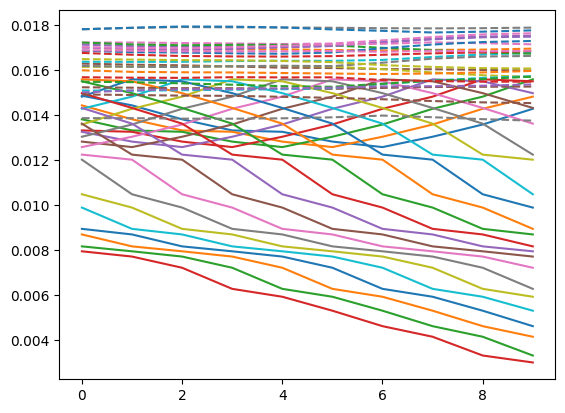

In [ ]:
# Überprüfe, ob das Modell auf der GPU oder der CPU ist
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Das Modell auf das entsprechende Gerät verschieben
model.to(device)

# Die Eingabedaten auch auf das gleiche Gerät verschieben
x_test = x_test.to(device)

# Vorhersagen mit dem Modell
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

print(x_test.shape)
print(y_pred.shape)
print(y_test.shape)
# Plotten der Ergebnisse
plt.plot(y_test.numpy(), label="Echter Wasserstand")
plt.plot(y_pred.cpu().numpy(), label="Vorhergesagter Wasserstand", linestyle="dashed")
#plt.legend()
plt.show()
